<a href="https://colab.research.google.com/github/sarjakpatel/CMPE_297_Advanced_Deep_Learning/blob/main/Assignment%202/CMPE_297_Assignment_2_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE 297: Assignment 2 Part 1: Graph Level Prediction using GCN

### Installing Pytorch Geometric and RDKit

- Pytorch Geometric => Build Graph Neural Network
- RDKit => Handle Molecule Data

In [1]:
# Enforce pytorch version 1.6.0
import torch
if torch.__version__ != '1.6.0':
  !pip uninstall torch -y
  !pip uninstall torchvision -y
  !pip install torch==1.6.0
  !pip install torchvision==0.7.0

# Check pytorch version and make sure you use a GPU Kernel
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!python --version
!nvidia-smi

Found existing installation: torch 1.12.1+cu113
Uninstalling torch-1.12.1+cu113:
  Successfully uninstalled torch-1.12.1+cu113
Found existing installation: torchvision 0.13.1+cu113
Uninstalling torchvision-0.13.1+cu113:
  Successfully uninstalled torchvision-0.13.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 748.8 MB 18 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.9 requires torchvision>=0.8.2, which is not installed.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.6.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.6.0 which is incompatible.
fastai 2.7.9 requires torch<1.14,>=1.7, but you have torch 1.6.0 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 17.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.9 requires torch<1.14,>=1.7, but you have torch 1.6.0 which is incompatible.
fastai 2.7.9 requires torchvision>=0.8.2, but you have torchvision 0.7.0 which is incompatible.
1.6.0
10.2
Python 3.7.15
Mon Oct 17 23:30:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                          

In [2]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO
 
 
logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)
 
 
def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """
 
    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )
 
    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)
 
    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return
 
        logger.info("force re-install")
 
    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)
 
    logger.info("python version: {}".format(python_version))
 
    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)
 
    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')
 
    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')
 
    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python==3.7.3",
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")
 
    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))
 
 
if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
INFO:__main__:add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.15
INFO:__main__:python version: 3.7.15
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
INFO:__main__:fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
INFO:__main__:done
installing miniconda to /root/miniconda
INFO:__main__:installing miniconda to /root/miniconda
done
INFO:__main__:done
installing rdkit
INFO:__main__:installing rdkit
done
INFO:__main__:done
rdkit-2020.09.1 installation finished!
INFO:__main__:rdkit-2020.09.1 installation finished!


In [3]:
import torch
pytorch_version = f"torch-{torch.__version__}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 15.5 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 36.0 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 39.7 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 29.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 20.5 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=7614178543cdeda86cfb85e75b8f6fcfa69e7e8c2c3e868601ccb997c05d4c06
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-

## **Dataset**

In [4]:
import rdkit
from torch_geometric.datasets import MoleculeNet
 
# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

Processing...
Done!


ESOL(1128)

In [5]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


In [6]:
# Investigating the features
# Shape: [num_nodes, num_node_features]
data[0].x

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [7]:
# Investigating the edges in sparse COO format
# Shape [2, num_edges]
data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

In [8]:
data[0].y

tensor([[-0.7700]])

In the following we will perform predictions based on the graph level. This means we have one y-label for the whole graph, as shown on the left image below. The right image would be node-level-predictions.

## Data Conversion

In [9]:
data[0]["smiles"]

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

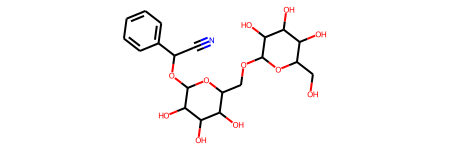

In [10]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [11]:
type(molecule)

rdkit.Chem.rdchem.Mol

## Building the Graph Neural Network

We apply three convolutional layers, which means we learn the information about 3 neighbor hops. After that we apply a pooling layer to combine the information of the individual nodes, as we want to perform graph-level prediction.

In [12]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


- We could also reduce the embeddings, but as we have large molecules we use 64
- The more layers we add, the more information we get about the graph
- For the regression problem we use a Linear layer as final output layer
- We try to use not too many parameters, as we only have ~1k samples

## Training the Model

In [13]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)     
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 11.665948867797852
Epoch 100 | Train Loss 0.8522763252258301
Epoch 200 | Train Loss 1.1232080459594727
Epoch 300 | Train Loss 0.32027918100357056
Epoch 400 | Train Loss 0.2339223027229309
Epoch 500 | Train Loss 0.3771529197692871
Epoch 600 | Train Loss 0.25315773487091064
Epoch 700 | Train Loss 0.0697125792503357
Epoch 800 | Train Loss 0.15051022171974182
Epoch 900 | Train Loss 0.16534322500228882
Epoch 1000 | Train Loss 0.06675136089324951
Epoch 1100 | Train Loss 0.03151068091392517
Epoch 1200 | Train Loss 0.07269114255905151
Epoch 1300 | Train Loss 0.05571999400854111
Epoch 1400 | Train Loss 0.016087373718619347
Epoch 1500 | Train Loss 0.01111324317753315
Epoch 1600 | Train Loss 0.06324620544910431
Epoch 1700 | Train Loss 0.011826425790786743
Epoch 1800 | Train Loss 0.056176938116550446
Epoch 1900 | Train Loss 0.0518941804766655


## Visualizing the Training loss

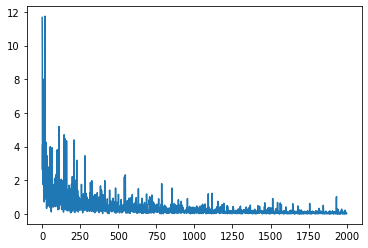

In [14]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

## Test and Evaluate the Model

In [15]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,0.940,0.654063
1,-6.237,-2.750615
2,-2.540,-2.369755
3,-5.680,-5.870438
4,-2.460,-1.774691
...,...,...
59,-1.890,-1.433651
60,-2.218,-4.396296
61,-3.583,-1.195101
62,-2.580,-2.334843


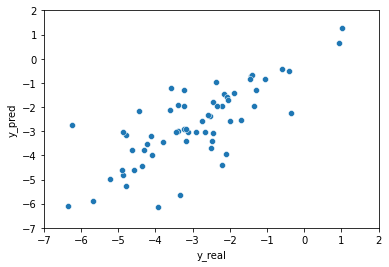

In [16]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

## **References**



- https://colab.research.google.com/drive/1IZcHH-Us7LuDBDCD5Z34Rbfui2XObFrn?usp=sharing#scrollTo=1BEIQNTF8Qei
- https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=j11WiUr-PRH_